## Importing libraries & Loading data

In [39]:
# import librares
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import tree

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import classification_report, confusion_matrix, f1_score, accuracy_score

In [40]:
# load data
df = pd.read_csv('ecommerce_consumers.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   ratio   200 non-null    float64
 1   time    200 non-null    float64
 2   label   200 non-null    object 
dtypes: float64(2), object(1)
memory usage: 4.8+ KB


## Exploratory Data Analysis

In [41]:
# first five rows
df.head(10)

,ratio,time,label
0,0.54,17.2,female
1,0.93,18.2,male
2,0.84,13.6,female
3,0.19,6.0,male
4,0.89,13.2,female
5,0.55,15.4,female
6,0.58,12.8,female
7,0.24,7.2,male
8,0.06,23.0,male
9,0.07,8.6,male


In [42]:
# descriptive summary
df.describe()

,ratio,time
count,200.000000,200.000000
mean,0.500900,14.826000
std,0.296443,5.313085
min,0.000000,6.000000
25%,0.247500,10.200000
50%,0.510000,14.800000
75%,0.747500,19.800000
max,1.000000,24.000000


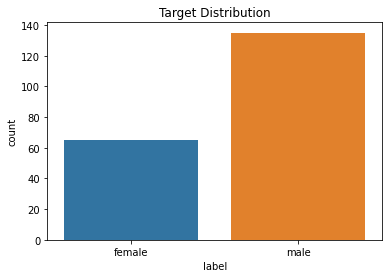

In [43]:
# target distribution
sns.countplot(x='label', data=df)
plt.title('Target Distribution');

In [44]:
def plot_binned(col, bin_num):
    bins=np.linspace(min(df[col]), max(df[col]), bin_num)
    print(bins)
    labels=['B'+str(i) for i in range(bin_num-1)]
    # binning
    df2=df.copy()
    df2[col+'_bin']=pd.cut(df[col], bins, labels=labels, include_lowest=True)
    return df2.groupby(col+'_bin')['label'].value_counts(normalize=True).unstack().plot(kind='bar', title=col, figsize=(12,6));

[0.  0.2 0.4 0.6 0.8 1. ]


<AxesSubplot:title={'center':'ratio'}, xlabel='ratio_bin'>

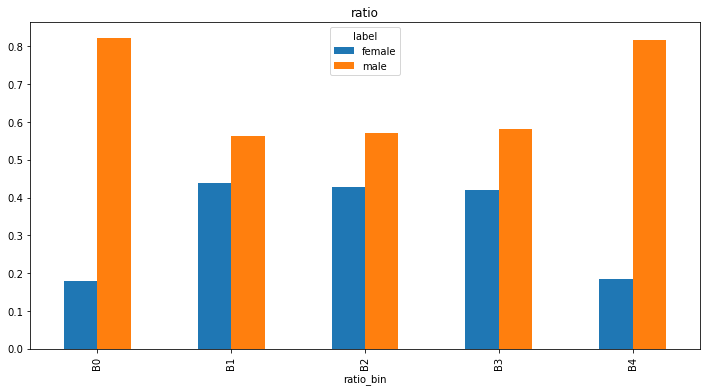

In [45]:
plot_binned('ratio',6)

[0.         0.33333333 0.66666667 1.        ]


<AxesSubplot:title={'center':'time'}, xlabel='time_bin'>

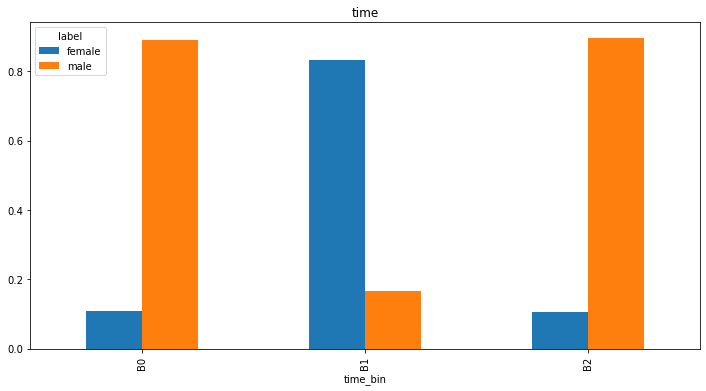

In [59]:
plot_binned('time',4)

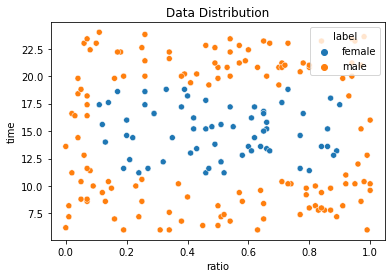

In [47]:
# data distribution
sns.scatterplot(x='ratio', y='time', data=df, hue='label')
plt.title('Data Distribution');

## Modelling

In [48]:
# scaling time column
mm = MinMaxScaler()
df['time']=mm.fit_transform(df[['time']])

In [49]:
# predictors
X = df.drop('label', axis=1)

# target
y = df['label']

# train test split
x_train, x_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.3, 
                                                    random_state=42)

### 1. Logistic Regression

In [50]:
lr = LogisticRegression()
lr.fit(x_train, y_train)

LogisticRegression()

In [51]:
y_pred = lr.predict(x_test)
print(classification_report(y_test, y_pred, zero_division=False))

              precision    recall  f1-score   support

      female       0.00      0.00      0.00        15
        male       0.75      1.00      0.86        45

    accuracy                           0.75        60
   macro avg       0.38      0.50      0.43        60
weighted avg       0.56      0.75      0.64        60



### 2. Decision Tree Classifier

In [52]:
# parameters
params = {'max_leaf_nodes': list(range(2, 10)),
          'ccp_alpha': [0.1, .01, .001],
          'max_depth' : [5, 6, 7, 8, 9],
          'min_samples_split': [2, 3, 4],
          'criterion' :['gini', 'entropy']}

# grid search
grid_search_cv = GridSearchCV(DecisionTreeClassifier(random_state=42), params, verbose=1, cv=5)
grid_search_cv.fit(x_train, y_train)

# best model
best_model = grid_search_cv.best_estimator_
best_model

Fitting 5 folds for each of 720 candidates, totalling 3600 fits


DecisionTreeClassifier(ccp_alpha=0.1, criterion='entropy', max_depth=5,
                       max_leaf_nodes=5, random_state=42)

In [53]:
# decision tree classifier
dtc = DecisionTreeClassifier(ccp_alpha=0.1, criterion='entropy', max_depth=5,
                       max_leaf_nodes=5, random_state=42)
dtc.fit(x_train, y_train)

# predicted values
y_pred = dtc.predict(x_test)
print(classification_report(y_test, y_pred, zero_division=False))

              precision    recall  f1-score   support

      female       1.00      1.00      1.00        15
        male       1.00      1.00      1.00        45

    accuracy                           1.00        60
   macro avg       1.00      1.00      1.00        60
weighted avg       1.00      1.00      1.00        60



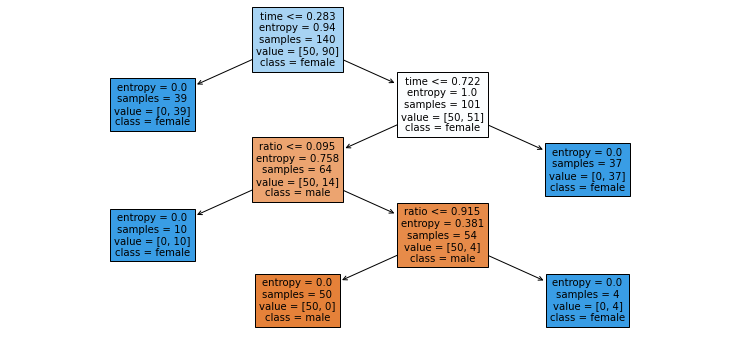

In [54]:
# visualizing tree
plt.figure(figsize=(13,6))
_=tree.plot_tree(dtc, feature_names=X.columns, class_names=y.value_counts().index, filled=True)

### 3. Support Vector Classifier

In [55]:
# accuracy scores for different kernals
for kernal in ['linear', 'poly', 'rbf', 'sigmoid']:
    svc = SVC(kernel=kernal)
    svc.fit(x_train, y_train)
    y_pred = svc.predict(x_test)
    print("Kernal : {:7} ; Accuracy Score : {}".format(kernal, round(accuracy_score(y_test, y_pred), 2)))

Kernal : linear  ; Accuracy Score : 0.75
Kernal : poly    ; Accuracy Score : 0.72
Kernal : rbf     ; Accuracy Score : 0.98
Kernal : sigmoid ; Accuracy Score : 0.45


 SVC with rbf kernal gave the best accuracy.

In [56]:
# model with rbf kernal
svc = SVC(kernel='rbf')
svc.fit(x_train, y_train)
y_pred = svc.predict(x_test)
print('Accuracy Score : {}'.format(round(accuracy_score(y_test, y_pred), 2)))

Accuracy Score : 0.98


In [57]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

      female       1.00      0.93      0.97        15
        male       0.98      1.00      0.99        45

    accuracy                           0.98        60
   macro avg       0.99      0.97      0.98        60
weighted avg       0.98      0.98      0.98        60



## Comparing performance of models in terms of accuracy

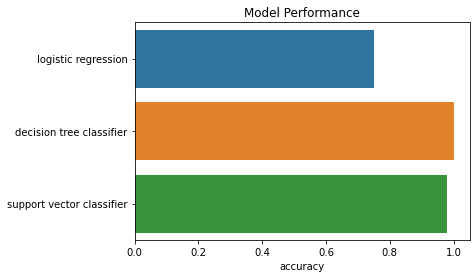

In [58]:
models = ['logistic regression', 'decision tree classifier', 'support vector classifier']
accuracy = [0.75, 1.00, 0.98]

# plot
plt.title('Model Performance')
plt.xlabel('accuracy')
sns.barplot(y=models,x=accuracy);